In [1]:
import re
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
dataset_name = 'webqsp'
with open(f"gpt_labeled_{dataset_name}_raw.jsonl") as f:
    data = [json.loads(line) for line in f]

In [10]:
# from strings to tuples of triplets
def get_tuples(input):
    trunc_cnt = 0
    pattern = r'(.*?)(,.*?\..*?\..*?,)(.*)'

    output_evi = []
    for evi in input:
        match = re.search(pattern, evi)
        if match is None or match.lastindex < 3:
            trunc_cnt += 1
        else:
            output_evi.append((match.group(1).replace('(', '').strip(), match.group(2)[1:-1].strip(), match.group(3).replace(')', '').strip()))
    return output_evi

In [11]:
non_exist_cnt = 0
total_cnt = 0
pattern = r'(.*?)(,.*?\..*?\..*?,)(.*)'
num_evi = []
for idx, each in enumerate(tqdm(data)):
    input_evi = each['user_query'].split('Question')[0].split('\n')[1:-2]
    input_evi = get_tuples(input_evi)

    output = each['prediction'].split('\n')
    output = [evi for evi in output if 'evidence:' in evi]
    output = [evi[evi.find('evidence:') + len('evidence:') + 1 :].strip() for evi in output]

    output_evi = get_tuples(output)
    good_evi = []
    for each_evi in output_evi:
        total_cnt += 1

        # two directions both count. in some cases, gpt will correct the order
        if (each_evi in input_evi or tuple(reversed(each_evi)) in input_evi):
            good_evi.append(each_evi)
        else:
            non_exist_cnt += 1
            # if non_exist_cnt == 100:
                # raise ValueError(f'{each_evi} not in {input_evi}')

    data[idx]['gpt_labeled_evi'] = good_evi
    num_evi.append(len(output_evi))

print(non_exist_cnt, total_cnt, non_exist_cnt / total_cnt)

100%|██████████| 1628/1628 [00:01<00:00, 1265.89it/s]

2175 22186 0.0980347967186514


100%|██████████| 1628/1628 [00:00<00:00, 797701.74it/s]


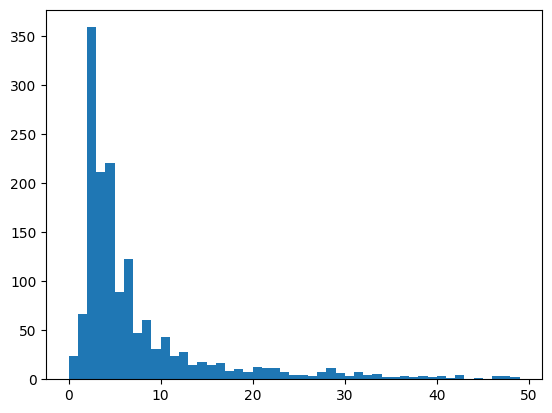

In [12]:
# for samples GPT provides more than 20 evidences, perhaps remove them
for idx, each in enumerate(tqdm(data)):
    if len(data[idx]['gpt_labeled_evi']) > 20:
        data[idx]['gpt_labeled_evi'] = []
fig = plt.hist(num_evi, bins=range(0, 50))

In [13]:
# count coverage of samples that GPT provides valid evidences
cnt = 0
for each in data:
    if len(each['gpt_labeled_evi']) > 0:
        cnt += 1
print(cnt, len(data), cnt / len(data))

1411 1628 0.8667076167076168


In [14]:
res = {}
for each in data:
    res[each['id']] = each['gpt_labeled_evi']

In [15]:
torch.save(res, f'gpt_labeled_{dataset_name}_cleaned.pt')

In [16]:
# res['WebQTest-832_c334509bb5e02cacae1ba2e80c176499']